In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
import pickle

In [4]:
df = pd.read_csv("churn.csv")


In [5]:
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995.0,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,449996.0,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,449997.0,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,449998.0,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [6]:
df = df.drop([
    "CustomerID",
    "Last Interaction",
    "Payment Delay"
], axis=1)

In [7]:
df = df.dropna(subset=["Churn", "Tenure"])
df.fillna(df.mean(numeric_only=True), inplace=True)

In [8]:
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})


In [9]:
df = pd.get_dummies(
    df,
    columns=["Subscription Type", "Contract Length"],
    drop_first=True
)

In [10]:
df

,Age,Gender,Tenure,Usage Frequency,Support Calls,Total Spend,Churn,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,30.0,0,39.0,14.0,5.0,932.00,1.0,False,True,False,False
1,65.0,0,49.0,1.0,10.0,557.00,1.0,False,False,True,False
2,55.0,0,14.0,4.0,6.0,185.00,1.0,False,False,False,True
3,58.0,1,38.0,21.0,7.0,396.00,1.0,False,True,True,False
4,23.0,1,32.0,20.0,5.0,617.00,1.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
440828,42.0,1,54.0,15.0,1.0,716.38,0.0,True,False,False,False
440829,25.0,0,8.0,13.0,1.0,745.38,0.0,True,False,False,False
440830,26.0,1,35.0,27.0,1.0,977.31,0.0,False,True,False,True
440831,28.0,1,55.0,14.0,2.0,602.55,0.0,False,True,False,True


In [11]:
df = df.rename(columns={
    "Tenure": "duration",
    "Churn": "event"
})


In [13]:
bool_cols = [
    "Subscription Type_Premium",
    "Subscription Type_Standard",
    "Contract Length_Monthly",
    "Contract Length_Quarterly"
]

df[bool_cols] = df[bool_cols].astype(int)


In [14]:
df

,Age,Gender,duration,Usage Frequency,Support Calls,Total Spend,event,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,30.0,0,39.0,14.0,5.0,932.00,1.0,0,1,0,0
1,65.0,0,49.0,1.0,10.0,557.00,1.0,0,0,1,0
2,55.0,0,14.0,4.0,6.0,185.00,1.0,0,0,0,1
3,58.0,1,38.0,21.0,7.0,396.00,1.0,0,1,1,0
4,23.0,1,32.0,20.0,5.0,617.00,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
440828,42.0,1,54.0,15.0,1.0,716.38,0.0,1,0,0,0
440829,25.0,0,8.0,13.0,1.0,745.38,0.0,1,0,0,0
440830,26.0,1,35.0,27.0,1.0,977.31,0.0,0,1,0,1
440831,28.0,1,55.0,14.0,2.0,602.55,0.0,0,1,0,1


In [15]:
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df["duration"],
    event_observed=df["event"]
)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 440832 total observations, 190833 right-censored observations>

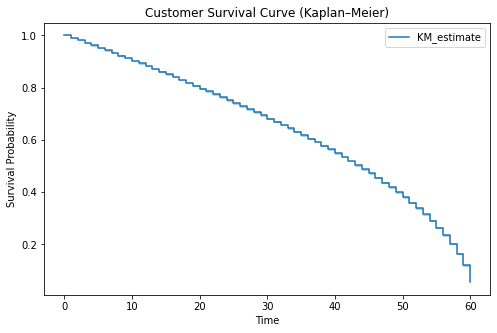

In [ ]:
plt.figure(figsize=(8, 5))
kmf.plot_survival_function()    
plt.title("Customer Survival Curve (Kaplan–Meier)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

In [17]:
cph = CoxPHFitter()
cph.fit(
    df,
    duration_col="duration",
    event_col="event"
)

<lifelines.CoxPHFitter: fitted with 440832 total observations, 190833 right-censored observations>

In [ ]:
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 440832 total observations, 190833 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 440832
number of events observed = 249999
   partial log-likelihood = -2961720.33
         time fit was run = 2026-01-16 17:49:40 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
Age                         0.01      1.01      0.00            0.01            0.01                1.01                1.01
Gender                     -0.19      0.83      0.00           -0.20           -0.18                0.82                0.84
Usage Frequency            -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Support Calls               0.12      1.13      0.00            0.12            0.12                1.12                1.13
Total Spend                -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Subscription Type_Premium  -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Subscription Type_Standard -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Contract Length_Monthly     0.51      1.67      0.00            0.50            0.52                1.65                1.69
Contract Length_Quarterly   0.00      1.00      0.00           -0.01            0.01                0.99                1.01

                            cmp to       z      p  -log2(p)
covariate                                                  
Age                           0.00   52.13 <0.005       inf
Gender                        0.00  -46.55 <0.005       inf
Usage Frequency               0.00   -5.87 <0.005     27.74
Support Calls                 0.00  184.78 <0.005       inf
Total Spend                   0.00 -121.80 <0.005       inf
Subscription Type_Premium     0.00   -0.19   0.85      0.24
Subscription Type_Standard    0.00   -0.82   0.41      1.29
Contract Length_Monthly       0.00  102.71 <0.005       inf
Contract Length_Quarterly     0.00    0.12   0.91      0.14
---
Concordance = 0.70
Partial AIC = 5923458.66
log-likelihood ratio test = 104577.76 on 9 df
-log2(p) of ll-ratio test = inf

In [19]:
print("\nConcordance Index (C-index):")
print(cph.concordance_index_)



Concordance Index (C-index):
0.698898967622329


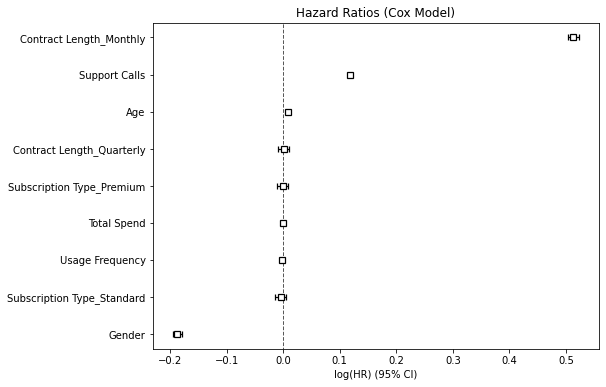

In [20]:
plt.figure(figsize=(8, 6))
cph.plot()
plt.title("Hazard Ratios (Cox Model)")
plt.show()
